#Implementación de un modelo de deep learning

##Procesamiento de datos

Introducción

Este proyecto busca resolver el problema de clasificación de diferentes tipos de zapatos en cinco categorías: Ballet Flat, Boat, Brogue, Clog y Sneaker. Esta clasificación es útil para aplicaciones como sistemas de recomendación de productos, organización automática de inventarios y análisis visual para tiendas en línea.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomRotation, RandomZoom, Dropout, BatchNormalization, ActivityRegularization, RandomFlip, RandomContrast, RandomHeight, RandomBrightness, RandomWidth, GlobalAveragePooling2D, Input, RandomTranslation, RandomCrop, GaussianNoise
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array


Usamos un dataset llamado “Shoes Classification Dataset,” que tiene alrededor de 13,000 imágenes de zapatos en cinco categorías. Cada tipo de zapato cuenta con unas 2,000 imágenes para entrenar el modelo. Este dataset ya está dividido en conjuntos de entrenamiento y validación. Antes de entrenar el modelo, las imágenes se normalizan para que los valores de los píxeles estén en un rango adecuado.

In [2]:
import os
from google.colab import files

# Cargar el archivo kaggle.json
files.upload()

# Crear el directorio .kaggle y mover kaggle.json ahí
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Cambiar los permisos del archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Descargar el dataset de zapatos
!kaggle datasets download -d utkarshsaxenadn/shoes-classification-dataset-13k-images

# Extraer el contenido del archivo zip
!unzip shoes-classification-dataset-13k-images.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Shoes Dataset/Train/Clog/Clog-Train (549).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (55).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (550).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (551).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (552).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (553).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (554).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (555).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (556).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (557).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (558).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (559).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (56).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (560).jpeg  
  inflating: Shoes Dataset/Train/Clog/Clog-Train (561).jpeg  
  inflating

In [4]:
!ls /content

 sample_data   shoes-classification-dataset-13k-images.zip  'Shoes Dataset'


El dataset ya venía dividido en entrenamiento, test y validación por lo que facilitó un poco el proceso de separación.

In [5]:
ruta_train = '/content/Shoes Dataset/Train'
ruta_test = '/content/Shoes Dataset/Test'
ruta_valid = '/content/Shoes Dataset/Valid'
IMAGE_SIZE = 128
BATCH_SIZE = 32

Convierte el dataset en un formato el cual el modelo acepta

In [6]:
# Cargar el conjunto de datos de imágenes y convertirlos en arreglos numpy
def load_dataset_as_arrays(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    images = []
    labels = []
    class_names = dataset.class_names

    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels, class_names


Se asignan las etiquetas a sus respectivas fotografías

In [7]:
# Cargar los datos de entrenamiento, validación y prueba
train_images, train_labels, class_names = load_dataset_as_arrays(ruta_train)
test_images, test_labels, _ = load_dataset_as_arrays(ruta_test)
val_images, val_labels, _ = load_dataset_as_arrays(ruta_valid)

Found 10000 files belonging to 5 classes.
Found 1215 files belonging to 5 classes.
Found 2500 files belonging to 5 classes.


In [8]:
# Convertir etiquetas a formato categórico
train_labels = to_categorical(train_labels, num_classes=len(class_names))
test_labels = to_categorical(test_labels, num_classes=len(class_names))
val_labels = to_categorical(val_labels, num_classes=len(class_names))

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0

##Primer modelo CNN

Este código define un modelo de aprendizaje profundo utilizando Keras. Se utiliza Sequential para construir el modelo capa por capa. Comienza con una entrada de imágenes de tamaño IMAGE_SIZE x IMAGE_SIZE y 3 canales, lo cual evita cualquier tipo de warning, seguido de capas de data augmentation  para mejorar la generalización. Luego, incluye tres bloques de capas convolucionales Conv2D con ReLU, cada una seguida por una capa de pooling MaxPooling2D para reducir las dimensiones. Después, los datos se aplanan con Flatten y se procesan en una capa densa con 512 neuronas antes de llegar a la salida Dense con activación softmax, que ajusta el modelo a múltiples clases. Finalmente, model.summary() imprime la arquitectura del modelo.

In [10]:
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(512, activation='relu'),
    Dense(len(class_names), activation='softmax')  # Ajustar la salida al número de clases
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,449,189 (24.60 MB)

 Trainable params: 6,449,189 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
acc = tf.keras.metrics.CategoricalAccuracy()

In [12]:
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=[acc])


In [13]:
history = model.fit(x=train_images, y=train_labels, validation_split=0.1, batch_size=32, epochs=50)


Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - categorical_accuracy: 0.2777 - loss: 1.5820 - val_categorical_accuracy: 0.3800 - val_loss: 1.5071
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - categorical_accuracy: 0.4043 - loss: 1.4387 - val_categorical_accuracy: 0.4750 - val_loss: 1.3701
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - categorical_accuracy: 0.4619 - loss: 1.3674 - val_categorical_accuracy: 0.4900 - val_loss: 1.3558
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - categorical_accuracy: 0.4823 - loss: 1.3239 - val_categorical_accuracy: 0.5560 - val_loss: 1.3009
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - categorical_accuracy: 0.5328 - loss: 1.2562 - val_categorical_accuracy: 0.5330 - val_loss: 1.2947
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - categorical_accuracy: 0.5727 - loss: 1.2052 - val_categorical_accuracy: 0.6030 - val_loss: 1.2021
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - categorical_accuracy: 

###Resultados del modelo

In [14]:
history_df = pd.DataFrame(history.history)
history_df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.321444,1.532185,0.380,1.507073
1,0.418444,1.427770,0.475,1.370144
2,0.466778,1.358852,0.490,1.355832
3,0.502667,1.309038,0.556,1.300865
4,0.534778,1.254354,0.533,1.294732
5,0.562111,1.214673,0.603,1.202103
6,0.590222,1.173674,0.586,1.207587
7,0.613000,1.136365,0.568,1.238780
8,0.640556,1.092214,0.566,1.264556
9,0.655778,1.070617,0.620,1.163718



El gráfico muestra que el modelo aprende bien en el entrenamiento, ya que la pérdida baja y la precisión sube. Sin embargo, en validación, los resultados dejan de mejorar y se mantienen estables, lo que sugiere que el modelo podría estar ajustándose demasiado a los datos de entrenamiento y no generalizando tan bien.

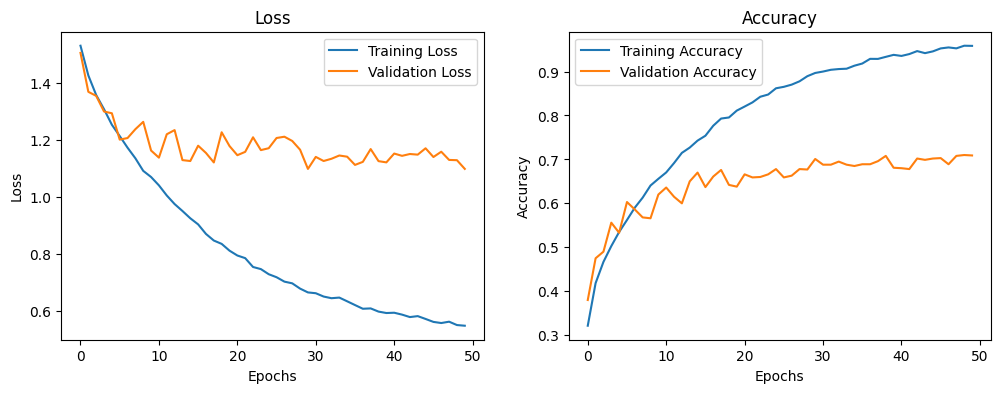

In [15]:
# Visualizar métricas de entrenamiento y validación
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

El siguiente bloque de código evalúa el rendimiento del modelo en el conjunto de prueba. La función model.evaluate calcula la pérdida y la precisión del modelo usando las imágenes y etiquetas de prueba. En este caso, la pérdida obtenida es de aproximadamente 1.24 y la precisión es de 0.63, lo que significa que el modelo clasifica correctamente alrededor del 60% de las imágenes en el conjunto de prueba. Aunque el modelo ha aprendido a distinguir las clases en cierto grado, hay margen para mejorar su precisión.

In [16]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.5953 - loss: 1.4162
Loss: 1.42
Accuracy: 0.60


##Segundo modelo CNN

Este modelo es similar al anterior, pero incluye capas de Dropout y regularización L2 para evitar el sobreajuste. Esto ayuda a que el modelo generalice mejor, reduciendo la dependencia de los datos de entrenamiento. Además, mantiene las mismas técnicas de data augmentation y estructura básica de capas convolucionales y densas.

In [22]:
model2 = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),

    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,449,189 (24.60 MB)

 Trainable params: 6,449,189 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

En los siguientes bloques de código se implementan varias técnicas para optimizar el proceso de entrenamiento del modelo. Primero, se define el optimizador Adam con una tasa de aprendizaje de 0.0005, lo cual permite que el modelo ajuste sus pesos de manera eficiente en cada iteración. También se define la métrica de precisión categórica, que nos ayudará a evaluar el desempeño del modelo durante y después del entrenamiento.

Luego, se configuran un callbacks para mejorar los resultados. EarlyStopping detiene el entrenamiento si no hay mejoras en la pérdida de validación después de varias épocas, evitando el sobreajuste. Esto se integran en el entrenamiento de este mnodelo, que se ejecuta durante 50 épocas con un tamaño del batch de 64, usando datos de entrenamiento y validación.

In [23]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model2.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=[acc])

histor2y = model2.fit(
    x=train_images,
    y=train_labels,
    validation_split=0.1,
    batch_size=64,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - categorical_accuracy: 0.2277 - loss: 2.3383 - val_categorical_accuracy: 0.3370 - val_loss: 1.7632
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - categorical_accuracy: 0.3242 - loss: 1.7238 - val_categorical_accuracy: 0.3990 - val_loss: 1.6016
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - categorical_accuracy: 0.3627 - loss: 1.5963 - val_categorical_accuracy: 0.4080 - val_loss: 1.5238
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - categorical_accuracy: 0.4034 - loss: 1.5188 - val_categorical_accuracy: 0.4610 - val_loss: 1.4628
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - categorical_accuracy: 0.4463 - loss: 1.4702 - val_categorical_accuracy: 0.4410 - val_loss: 1.4489
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - categorical_accuracy: 0.4558 - loss: 1.4487 - val_categorical_accuracy: 0.5100 - val_loss: 1.3952
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - categorical_accuracy: 0.473

In [25]:
history2_df = pd.DataFrame(histor2y.history)
history2_df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.259889,2.057060,0.337,1.763160
1,0.329778,1.687261,0.399,1.601573
2,0.369556,1.577095,0.408,1.523773
3,0.414889,1.507672,0.461,1.462811
4,0.443000,1.468209,0.441,1.448874
5,0.454667,1.445322,0.510,1.395243
6,0.468111,1.432161,0.482,1.400963
7,0.482222,1.417419,0.518,1.376014
8,0.491333,1.401412,0.521,1.340126
9,0.507111,1.392316,0.532,1.384798


El gráfico muestra que el modelo aprende de manera equilibrada. La pérdida de entrenamiento y validación bajan casi al mismo ritmo, lo que indica que el modelo no está sobreajustándose. Además, la precisión de entrenamiento y validación aumentan juntas y se mantienen cercanas, demostrando que el modelo generaliza bien.

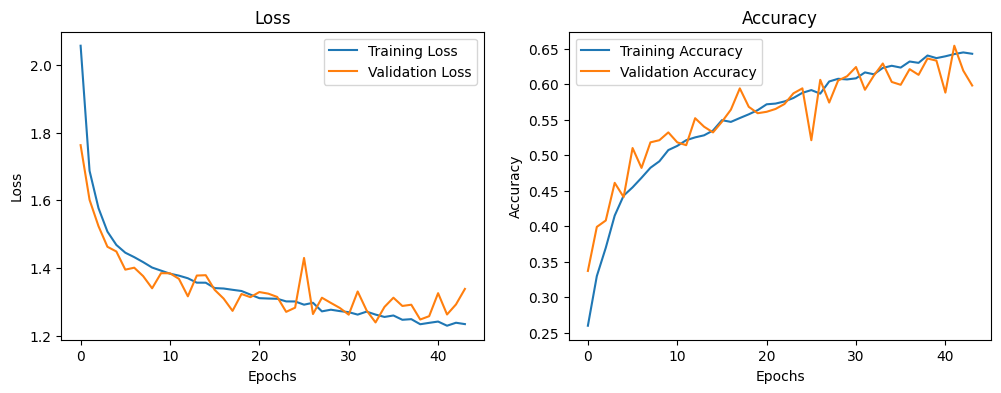

In [26]:
# Visualizar métricas de entrenamiento y validación
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(histor2y.history['loss'], label='Training Loss')
plt.plot(histor2y.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(histor2y.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(histor2y.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

###Resultados del segundo modelo

El modelo tiene un desempeño moderado en los datos de prueba, con una pérdida de 1.47 y una precisión de 51%. Esto indica que el modelo no generaliza tan bien como se esperaba y aún tiene margen para mejorar en su capacidad de clasificar correctamente.

In [27]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model2.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.5042 - loss: 1.4401
Loss: 1.47
Accuracy: 0.51


##Tercer modelo


Este modelo es más avanzado, ya que incluye técnicas como Batch Normalization para estabilizar el aprendizaje y Dropout con diferentes tasas para evitar el sobreajuste. Además, utiliza data augmentation y una arquitectura más profunda con capas convolucionales adicionales, aumentando su capacidad para aprender características complejas. También implementa un optimizador Adam con un learning rate ajustado y callbacks como EarlyStopping y ReduceLROnPlateau, que ayudan a optimizar el entrenamiento evitando entrenar de más y ajustando la tasa de aprendizaje cuando sea necesario.


In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [34]:
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [35]:
from tensorflow.keras.optimizers import Adam


In [36]:
from tensorflow.keras.optimizers import RMSprop  # Importar RMSprop


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, RandomFlip, RandomRotation, Input
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Definición del modelo con regularización, batch normalization y data augmentation
model3 = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Resumen del modelo
model3.summary()

# Compilación del modelo con un learning rate ajustado
optimizer = Adam(learning_rate=1e-4)
model3.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['categorical_accuracy']
)

# Configuración de callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Entrenamiento del modelo
history3 = model3.fit(
    train_images,
    train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,130,437 (19.57 MB)

 Trainable params: 5,129,925 (19.57 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - categorical_accuracy: 0.2377 - loss: 3.1586 - val_categorical_accuracy: 0.2035 - val_loss: 2.5626 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - categorical_accuracy: 0.2593 - loss: 2.6778 - val_categorical_accuracy: 0.1950 - val_loss: 2.5800 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - categorical_accuracy: 0.3053 - loss: 2.4824 - val_categorical_accuracy: 0.2295 - val_loss: 2.5505 - learning_rate: 1.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - categorical_accuracy: 0.3295 - loss: 2.4214 - val_categorical_accuracy: 0.2180 - val_loss: 2.5247 - learning_rate: 1.0000e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - categorical_accuracy: 0.3486 - loss: 2.3792 - val_categorical_accuracy: 0.2325 - val_loss: 2.4972 - learning_rate: 1.0000e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - categorical_accuracy: 0.3798 - los

Los graficos muestran que tanto la pérdida como la precisión de entrenamiento y validación mejoran de manera consistente. La pérdida de validación se mantiene cerca de la de entrenamiento, lo que indica que el modelo está aprendiendo bien y generalizando mejor que los anteriores. Aunque la precisión de validación sube de forma menos uniforme, el modelo sigue mostrando un buen desempeño.

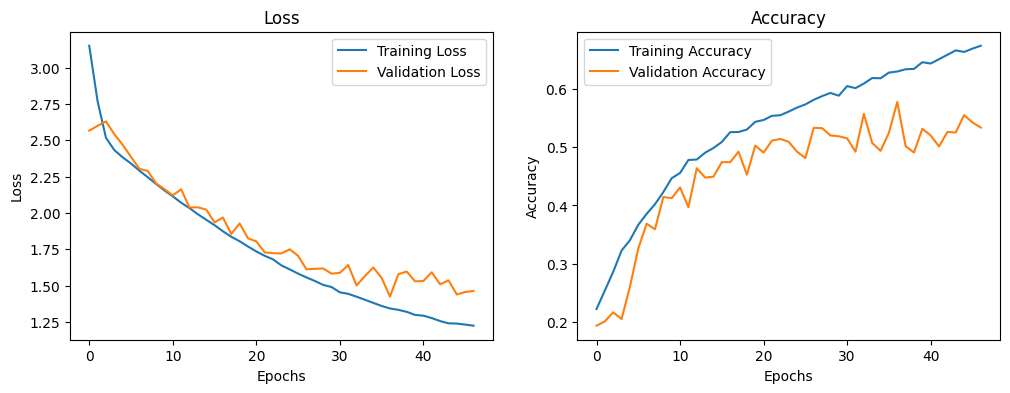

In [38]:
# Visualizar métricas de entrenamiento y validación
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history3.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model3.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

##Cuarto


Este modelo mejora significativamente respecto a los anteriores al incluir una capa de Global Average Pooling, que simplifica la salida antes de pasar a las capas densas, reduciendo parámetros innecesarios y haciendo el modelo más eficiente. Además, mantiene elementos clave como Dropout, Batch Normalization y regularización L2, lo que refuerza su capacidad para aprender y evitar el sobreajuste. La arquitectura más profunda, junto con un optimizador Adam ajustado y callbacks efectivos, lo hacen más sólido en términos de rendimiento y generalización.

Comparado con los otros modelos, es más avanzado que los modelos 1 y 2, ya que estos no incluían ni la capa de Batch Normalization ni las mejoras en el diseño general. Frente al modelo 3, el uso de Global Average Pooling le da una ventaja en eficiencia y estabilidad, lo que podría traducirse en un mejor desempeño en datos de validación y prueba. Este modelo combina lo mejor de las estrategias anteriores, optimizando tanto la capacidad de aprendizaje como su habilidad para generalizar.

In [42]:
model4 = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    BatchNormalization(),

    # Global Average Pooling Layer
    GlobalAveragePooling2D(),

    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Resumen del modelo
model4.summary()

# Compilación del modelo con un learning rate ajustado
optimizer = Adam(learning_rate=1e-4)
model4.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['categorical_accuracy']
)

# Configuración de callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history4 = model4.fit(
    train_images,
    train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_6 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_6 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_6 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 542,917 (2.07 MB)

 Trainable params: 542,405 (2.07 MB)

 Non-trainable params: 512 (2.00 KB)

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - categorical_accuracy: 0.2562 - loss: 1.9326 - val_categorical_accuracy: 0.2020 - val_loss: 1.9297 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - categorical_accuracy: 0.2975 - loss: 1.8661 - val_categorical_accuracy: 0.2515 - val_loss: 1.9293 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - categorical_accuracy: 0.3588 - loss: 1.7940 - val_categorical_accuracy: 0.2260 - val_loss: 1.8826 - learning_rate: 1.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - categorical_accuracy: 0.3810 - loss: 1.7526 - val_categorical_accuracy: 0.2355 - val_loss: 1.8197 - learning_rate: 1.0000e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - categorical_accuracy: 0.4051 - loss: 1.7037 - val_categorical_accuracy: 0.3420 - val_loss: 1.7400 - learning_rate: 1.0000e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - categorical_accuracy: 0.4408 - loss: 1.6557 -

In [44]:
history4_df = pd.DataFrame(history4.history)
history4_df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss,learning_rate
0,0.268750,1.914313,0.2020,1.929721,0.000100
1,0.316750,1.849015,0.2515,1.929285,0.000100
2,0.359875,1.783467,0.2260,1.882569,0.000100
3,0.394500,1.734438,0.2355,1.819742,0.000100
4,0.418875,1.690485,0.3420,1.739991,0.000100
5,0.442875,1.650408,0.4145,1.688622,0.000100
6,0.455125,1.624037,0.3620,1.740054,0.000100
7,0.477750,1.589887,0.3705,1.738739,0.000100
8,0.483000,1.565576,0.4045,1.695038,0.000100
9,0.488875,1.540483,0.4010,1.674735,0.000100



El modelo 4 muestra un buen balance entre aprendizaje y generalización. La pérdida de entrenamiento y validación disminuyen juntas, lo que indica que no hay sobreajuste. La precisión de entrenamiento sube de forma constante, mientras que la de validación también mejora, aunque con algunas variaciones. En general, el modelo aprovecha bien las mejoras implementadas, como la regularización y el Global Average Pooling, logrando un desempeño estable.

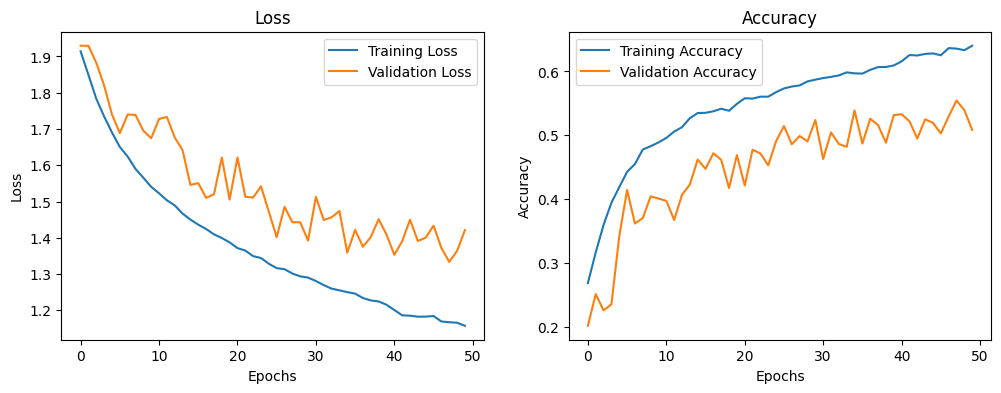

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history4.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [46]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model4.evaluate(test_images, test_labels)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.4325 - loss: 1.5333
Loss: 1.58
Accuracy: 0.42


###Predicciones

Los siguientes bloques de código son con la finalidad de poder predecir una imagen, es decir poner en practica el modelo

In [49]:
best_val_loss = {
    'model1': min(history.history['val_loss']),
    'model2': min(histor2y.history['val_loss']),
    'model3': min(history3.history['val_loss']),
    'model4': min(history4.history['val_loss']),
}

best_model_name = min(best_val_loss, key=best_val_loss.get)
print(f"El mejor modelo es: {best_model_name}")

# Seleccionar el mejor modelo
if best_model_name == 'model1':
    best_model = model
elif best_model_name == 'model2':
    best_model = model2
elif best_model_name == 'model3':
    best_model = model3
elif best_model_name == 'model4':
    best_model = model4

# Guardar el mejor modelo en formato .keras
best_model.save(f"{best_model_name}.keras")
print(f"El mejor modelo ha sido guardado como {best_model_name}.keras")


El mejor modelo es: model1
El mejor modelo ha sido guardado como model1.keras


In [51]:
best_model = tf.keras.models.load_model(f"{best_model_name}.keras")

# Función para predecir una imagen
def predict_image(image_path, model, image_size):
    img = load_img(image_path, target_size=(image_size, image_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Realizar predicción
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class[0]

# Ejemplo de uso
image_path = "prueba.jpg"
predicted_class = predict_image(image_path, best_model, IMAGE_SIZE)
print(f"La clase predicha es: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
La clase predicha es: Brogue


##Conclusiones


Aunque los modelos posteriores introdujeron mejoras como regularización, Dropout, Batch Normalization y Global Average Pooling, el modelo 1 tuvo el mejor desempeño general. Esto se debe a que su simplicidad y menor complejidad evitaron problemas de ajuste excesivo o pérdida de capacidad de aprendizaje, logrando un mejor equilibrio entre precisión y pérdida en los datos de validación. En resumen, a veces, un modelo más simple puede ser más efectivo cuando los datos y el problema no requieren arquitecturas demasiado sofisticadas.